# Background to osteoarthritis case study

This lecture is taken from the [5-day JADS NHS PROMs data science case study](https://github.com/jads-nl/execute-nhs-proms/blob/master/README.md). 

In the previous lectures we have worked on data understanding and data preparation. In this lecture we will estimate a few simple models.

# Learning objectives

The main objective in this lecture is to learn how to train and interpret a number of commonly applied machine learning algorithms. In this notebook we will look at the following algorithms:
- Regression
- LASSO
- K-nearest neighbors

In the next notebook we will consider:
- Decision Tree
- Random Forest
- Gradient Boosting

To get experience with both numeric and categorical outcome measures, we apply the models in this notebook to predict a numeric outcome `t1_eq_vas`. The models applied in the next notebook will aim to predict a categorical outcome. 

# Importing data and settings

We start with importing the modules we generally need when working with data. The modules required for more specific tasks will be imported when they are needed, such that it is more obvious where and how these modules are used.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


We can define a number of default settings for making graphs, such that it is easier to make graphs later on in the notebook. 

In [2]:
# To plot pretty figures directly within Jupyter
%matplotlib inline

# choose your own style: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-whitegrid')

# Go to town with https://matplotlib.org/tutorials/introductory/customizing.html
# plt.rcParams.keys()
mpl.rc('axes', labelsize=14, titlesize=14)
mpl.rc('figure', titlesize=20)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# constants for figsize
S = (8,8)
M = (12,12)
L = (14,14)

/var/folders/25/nx21zx0953z8ygknd3s94wmr0000gn/T/ipykernel_44613/1957301793.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Another way to make it easier to work with our data in a notebook environment is to define the display options.

In [3]:
# pandas options
pd.set_option("display.max.columns", None)
pd.set_option("display.max.rows", None)
pd.set_option("display.precision", 2)

Finally, we can also choose to supress warnings (not errors!) to enhance readibility of our output.

In [4]:
import warnings

#supressing warnings for readability
warnings.filterwarnings("ignore")

The last step is to import the data, after which we are ready to start preparing and modeling the data.

In [5]:
# import data
df = pd.read_parquet('https://github.com/jads-nl/execute-nhs-proms/blob/master/data/interim/knee-provider.parquet?raw=true')

# Splitting the data

We apply stratified shuffle split, which ensures a similar distribution of our outcome measure in both the training and the test set. This requires that we specify the outcome measure (which should have a similar distribution in the train and test data), and that this outcome measure contains no missing data.

### Question 1a

Working on a data problem very often starts with a thorough exploration of the outcome measure. For now, provide the summary statistics for `t1_eq_vas`, provide the number of missings, and plot a histogram.

### Question 1b

The domain expert tells you that eq_vas is defined on a range of 0-100, and that values of 999 are used to indicate missing values. Describe how often the value 999 occurs.

To ensure that we can apply StratifiedShuffleSplit, the code below imputes the missings (value 999) with the median. Please be aware of the risks of imputing your outcome data, as described in the previous notebook! 

In [6]:
# replacing the sentinal value 999 with the median
df["t1_eq_vas_impute"] = df.t1_eq_vas.replace(
    to_replace=999, value=np.median(df.t1_eq_vas)
)

We now define a temporary categorical feature, defined by the deciles of `t1_eq_vas`, which is then used to split the data (ensuring that the train and test data have the same decile distribution of eq_vas values.

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

# add t1_eq_vas deciles
df['t1_eq_vas_cat'] = pd.cut(df.t1_eq_vas_impute, 10)

# introducing 1 split, to set aside 30% (0.30) of the data as test data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['t1_eq_vas_cat']):
    df_train = df.loc[train_index]
    df_test = df.loc[test_index]

### Question 2

- Plot the distributions (histograms) of `t1_eq_vas_impute` in both the train and the test set
- Now that the data were split into a train and test set, ensuring a similar distribution of t1_eq_vas, please remove the variables `t1_eq_vas_impute` and `t1_eq_vas_cat` from both the train and the test set.

# Data preparation in a scikit-learn Pipeline

When preparing data such that it can be used for modeling, we have to set up the process such that:

* ...information from the test set is not used, as this makes model performance unreliable (known as data leakage);

* ...it is easy to try out different choices of preparing the data, such as applying pre-processing through a [parameter search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search).

For this purpose, the [`ColumnTransformer` class](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html?highlight=columntransformer#sklearn.compose.ColumnTransformer) is available in scikit-learn, which is demonstrated below.



## Using ColumnTransformers and Pipelines

As in the previous notebook, we want to perform preprocessing steps on (groups of) columns. The use of `Pipeline` is always recommended, and even more so when a feature requires more than one preprocessing step.

In our example, we require the following modules: 

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

To make it easier to work with our features, we define groups of features with features requiring similar preprocessing steps.

In [9]:
# define variable groups, to enhance readability 
age_band = ["age_band"]
gender = ["gender"]
age_band_categories = sorted([x for x in df.age_band.unique() if isinstance(x, str)])
comorb = [
    "heart_disease",
    "high_bp",
    "stroke",
    "circulation",
    "lung_disease",
    "diabetes",
    "kidney_disease",
    "nervous_system",
    "liver_disease",
    "cancer",
    "depression",
    "arthritis",
]

# create a group for the dummy variables
boolean = ["t0_assisted", "t0_previous_surgery", "t0_disability"]

# create a group for the five questions that make up the EQ5D
eq5d = ["t0_mobility", "t0_self_care", "t0_activity", "t0_discomfort", "t0_anxiety"]
eq_vas = ["t0_eq_vas"]
categorical = ["t0_symptom_period", "t0_previous_surgery", "t0_living_arrangements"]

# create a group for all OKS questions
oks_questions = [
    col for col in df.columns if col.startswith("oks_t0") and not col.endswith("_score")
]
oks_score = ["oks_t0_score"]

### Question 3
Describe the frequencies of the levels for each of the features in 'categorical'

We now define the preprocessing steps for each set of features where different preprocessing steps are required. Preprocessing depend on the imputation strategy (median of most frequent), the values to be imputed (nan, 9 or 999), and the encoding of levels (OneHotEncoding, where each level is defined as an individual dummy variable, or OrdinalEnconding). 

We start with defining the pipeline elements for age and gender, followed by a set of straightforward imputation strategies for different categories of features.

In [10]:
# define preprocessing pipelines for age and gender columns
age_band_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
        ("ordinal", OrdinalEncoder(categories=[age_band_categories])),
    ]
)

gender_pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
                   ('onehot', OneHotEncoder()),
    ]
)

The age and gender pipelines are now encapsulated in the `transformers` object below, along with the imputation strategies for other sets of features.

In [11]:
# ColumnTransformer on features that should be included in the prepared dataset.
transformers = {
    "age": ("age", age_band_pipe, age_band),
    "gender": ("gender", gender_pipe, gender),
    
    "comorb": ( 
        "comorb",
        SimpleImputer(missing_values=9, strategy="constant", fill_value=0),
        comorb,
    ),
    
    "categorical": (
        "categorical",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        boolean + eq5d + categorical,
    ),
    
    "oks": (
        "oks",
        SimpleImputer(missing_values=9, strategy="most_frequent"),
        oks_questions,
    ),
    
    "oks_score": (
        "oks_score",
        SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
        oks_score,
    ),
    
    "eq_vas": ("eqvas", SimpleImputer(missing_values=999, strategy="median"), eq_vas),
}

The transformers object is now a dictionary containing each of the elements just defined.

In [12]:
transformers.items()

dict_items([('age', ('age', Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('ordinal',
                 OrdinalEncoder(categories=[['40 to 49', '50 to 59', '60 to 69',
                                             '70 to 79', '80 to 89',
                                             '90 to 120']]))]), ['age_band'])), ('gender', ('gender', Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder())]), ['gender'])), ('comorb', ('comorb', SimpleImputer(fill_value=0, missing_values=9, strategy='constant'), ['heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease', 'diabetes', 'kidney_disease', 'nervous_system', 'liver_disease', 'cancer', 'depression', 'arthritis'])), ('categorical', ('categorical', SimpleImputer(missing_values=9, strategy='most_frequent'), ['t0_assisted', 't0_previous_surgery', 't0_disability', 't0_mobility', 't0_self_care', 't0_activity', 't0_discomfort', 't0_anxiety', 't0_

We can now loop over the different items in the transformers object to create the `prep` object below. Note that features not listed within `transformers` will not be dropped by default when applying `.fit_transform` or `.transform`

In [13]:
prep = ColumnTransformer(transformers=[v for _, v in transformers.items()])

This `prep` object can now be applied to df_train (using fit_transform) and to df_test (using transform).

In [14]:
X_train = prep.fit_transform(df_train)
X_test = prep.transform(df_test)

As we saw in previous scripts, X_train and X_test will no longer contain the original column names as contained in df_train and df_test.

For convenience, we create `X_columns`, containing the names of all the transformed columns. We therefore have to define `X_columns` using all elements in transformers in the same order, and pay extra attention to transformer elements where additional columns were created.

In [15]:
# list of columns for convenience
# https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-name-after-onehotencode-in-columntransformer
X_columns = pd.Series(
    age_band
    + prep.named_transformers_["gender"]["onehot"].get_feature_names_out().tolist()
    + comorb
    + boolean
    + eq5d
    + categorical
    + oks_questions
    + oks_score
    + eq_vas
)

### Question 4
Show the first ten rows of the pandas dataframe containing X_train data along with the appropriate columns names.

# Modeling

In this notebook you will develop models that predict the numeric outcome `t1_eq_vas`. We start with exploring regression models before we apply LASSO and KNN.

## Regression

When predicting `t1_eq_vas`, we naturally expect `t0_eq_vas` to be an important predictor. To check our expectations we can first plot the relation between these variables:

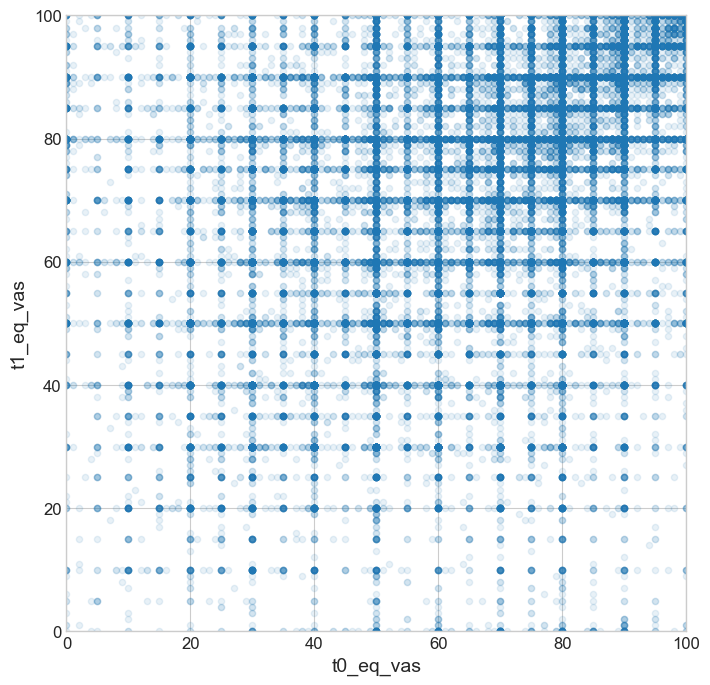

In [16]:
df_train.plot(kind='scatter', x='t0_eq_vas', y='t1_eq_vas', xlim=(0,100), ylim=(0,100), alpha=0.1, figsize=S);

We start with applying a linear regression to see how much of eq_vas at t1 is explained by eq_vas at t0 in a simple (linear) baseline model.

First, we prepare the outcome data by applying median imputation on the missing values.

In [17]:
Y_imputer = SimpleImputer(missing_values=999, strategy = 'median')
Y_imputer.fit(df_train['t1_eq_vas'].to_frame())
Y_imputer.statistics_

array([80.])

Missings for `t1_eq_vas` are imputed using this median value, and the resulting distribution is shown below.

array([[<Axes: title={'center': 't1_eq_vas'}>]], dtype=object)

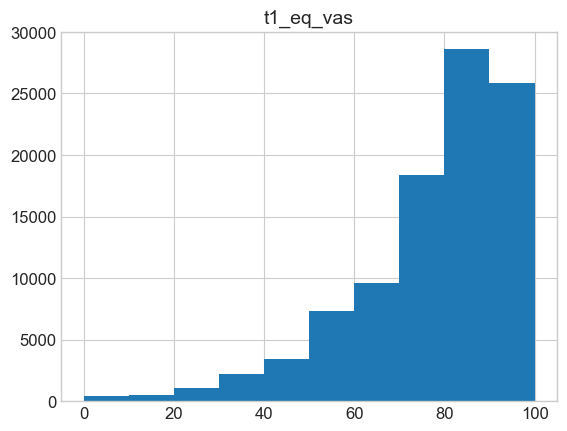

In [18]:
t1_eq = Y_imputer.transform(df_train['t1_eq_vas'].to_frame())
pd.DataFrame(data = t1_eq, columns = ['t1_eq_vas']).hist()

The same can be done for the outcome measure in the test data

array([[<Axes: title={'center': 't1_eq_vas_test'}>]], dtype=object)

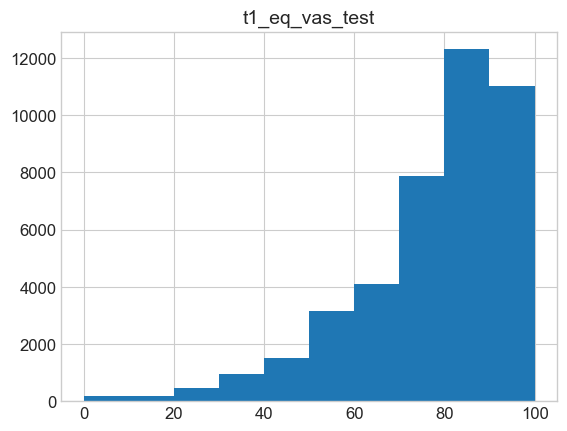

In [19]:
# prepare t1_eq_test for use later on in model assessment
t1_eq_test = Y_imputer.transform(df_test['t1_eq_vas'].to_frame())
pd.DataFrame(t1_eq_test, columns = ['t1_eq_vas_test']).hist()

The code below fits a linear regression to predict t1_eq_vas using t0_eq_vas

In [20]:
from sklearn.linear_model import LinearRegression

t0_eq = pd.DataFrame(data = X_train, columns = X_columns)['t0_eq_vas'].to_frame()

lin_reg = LinearRegression()
lin_reg.fit(t0_eq, t1_eq)


LinearRegression()

### Question 5

The intercept, beta-coefficient and the R^2 (coefficient of determination) can be obtained from lin_reg. Consult the documentation for LinearRegression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) and extract the intercept, beta-coefficient and the R^2.

We normally should add **cross-validation** to our model building process to be able to properly compare different model options in terms of performance, which becomes necessarywhen training models that contain hyperparameters. 

Next to the choices you have on how to build your models, you also have choices to make regarding the performance metric, being the 'thing' that your model will optimize. Let's apply Mean Squared Error (MSE) as our metric in the next iteration:

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")

scores = cross_val_score(lin_reg, t0_eq, t1_eq, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [16.66593682 16.82464722 16.87729003 16.88592997 16.93669798]
Mean: 16.8381
Standard deviation: 0.0931


The reported root of the MSE of around 16.8 tells us that given a predicted value, the true outcome is likely to be in the interval of 2 * 16.8 below and 2 * 16.8 above the predicted value. This results in a range of around 65 points for an outcome measure ranging from 0 to 100, which is substantial, and confirms that a simple linear model will not do the trick. 

Now that we have seen the simplest setup for a linear regression with only one predictor, let's use linear regression to try to find out which features are the best predictors.

### SelectKBest

There are various techniques to determine which features give the best prediction in a regression, such as stepwise selection. Scikit-learn has various [univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html) methods for this purpose. We will use [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest).


In [22]:
from sklearn.feature_selection import SelectKBest, f_regression

k10best = Pipeline(
    steps=[
        ("prep", ColumnTransformer(transformers=transformers.values())),
        ("kbest", SelectKBest(f_regression, k=10)),
    ]
)

X_10best = k10best.fit(df_train, t1_eq).transform(df_train)
lin_10best = LinearRegression()
scores_10best = cross_val_score(lin_10best, X_10best, t1_eq, scoring='neg_mean_squared_error', cv=5)
lin_10best_rmse_scores = np.sqrt(-scores_10best)
display_scores(lin_10best_rmse_scores)

Scores: [15.99162775 16.14324365 16.17794808 16.22819153 16.19174312]
Mean: 16.1466
Standard deviation: 0.0821


Using the 10 Best features, the model performs only slightly better with an RMSE of 16.1 +/- 0.08 compared to the 16.8 +/- 0.09 found when only using t0_eq_vas.

The code below shows the features in descending order of importance, which (unexpectedly) puts eq_t0_vas at the top of the list. 

In [23]:
pd.concat(
        {"score": pd.Series(k10best["kbest"].scores_), "feature": X_columns}, axis=1
    ).sort_values("score", ascending=False)


,score,feature
39,12988.61,t0_eq_vas
38,8612.77,oks_t0_score
36,8036.19,oks_t0_shopping
19,7386.24,t0_self_care
17,6930.16,t0_disability
28,6620.98,oks_t0_washing
22,6559.51,t0_anxiety
37,5421.20,oks_t0_stairs
34,5213.64,oks_t0_work
29,4438.80,oks_t0_transport


It is important to realize that linear regression is simply to be used as a baseline model; do not put too much effort into tuning; mainly use it to increase your understanding of the data and as a means of face validity, i.e. to see if there is nothing striking in the importance ranking, which could be indicative of errors in your data, in your data preparation or in your modeling approach. 


So even though you are in the CRISP-DM Modeling phase at this point, approach building a baseline model as helping you to increase your Data Understanding. This is exactly why it is important to not only estimate your baseline model and its performance, but also to describe it from different angles, by showing features in descending order of importance, but also by looking into the coefficients for each feature and their signs (i.e. whether they contribute to higher of lower outcomes).

To this purpose, let's estimate the regression with the 10 best features, such that we can inspect their coefficients. Let's start with showing the dataframe for these 10 features.

In [24]:
cols = k10best['kbest'].get_support(indices=True)
X_set = pd.DataFrame(X_10best, columns=X_columns[cols])
X_set.head(10)

,t0_disability,t0_self_care,t0_anxiety,oks_t0_washing,oks_t0_transport,oks_t0_work,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t0_eq_vas
0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,18.0,90.0
1,2.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,18.0,85.0
2,2.0,1.0,1.0,3.0,3.0,1.0,3.0,2.0,21.0,87.0
3,1.0,1.0,1.0,4.0,2.0,2.0,2.0,2.0,23.0,90.0
4,2.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,23.0,50.0
5,2.0,1.0,1.0,3.0,2.0,2.0,3.0,1.0,19.0,55.0
6,1.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,18.0,95.0
7,1.0,1.0,1.0,3.0,2.0,1.0,3.0,2.0,19.0,70.0
8,2.0,1.0,1.0,4.0,3.0,2.0,3.0,2.0,24.0,95.0
9,2.0,1.0,2.0,4.0,2.0,1.0,2.0,3.0,19.0,40.0


In [25]:
X_set.describe()

,t0_disability,t0_self_care,t0_anxiety,oks_t0_washing,oks_t0_transport,oks_t0_work,oks_t0_shopping,oks_t0_stairs,oks_t0_score,t0_eq_vas
count,97465.00,97465.00,97465.00,97465.00,97465.00,97465.00,97465.00,97465.00,97465.00,97465.0
mean,1.47,1.30,1.39,2.81,2.07,1.41,1.85,1.78,18.96,67.5
std,0.50,0.47,0.56,1.00,0.83,0.87,1.20,0.89,7.70,19.7
min,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0
25%,1.00,1.00,1.00,2.00,2.00,1.00,1.00,1.00,13.00,55.0
50%,1.00,1.00,1.00,3.00,2.00,1.00,2.00,2.00,19.00,70.0
75%,2.00,2.00,2.00,4.00,2.00,2.00,3.00,2.00,24.00,80.0
max,2.00,3.00,3.00,4.00,4.00,4.00,4.00,4.00,48.00,100.0


With these features, we can estimate a Linear Regression and extract the feature coefficients.

In [26]:
lin_reg_full = LinearRegression()
lin_reg_full.fit(X_set, t1_eq)
pd.DataFrame(lin_reg_full.coef_.transpose(), X_columns[cols], columns=['Coefficients'])

,Coefficients
t0_disability,4.10
t0_self_care,-3.03
t0_anxiety,-3.21
oks_t0_washing,0.88
oks_t0_transport,0.15
oks_t0_work,0.39
oks_t0_shopping,1.12
oks_t0_stairs,0.51
oks_t0_score,-0.06
t0_eq_vas,0.20


The larger coefficients with contrasting signs for variables containing information that is 'pointing in the same direction' (disability / self care / anxiety) might indicate multicollinearity, which could possibly introduce some model instability. 

## LASSO Regression

We will now apply LASSO regression, applied to the same numeric outcome (in contrast to the applying LASSO to a binary outcome, as seen before). We apply LASSO, a so-called regularized version of a normal regression, using cross-validation (following the example from [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html#sphx-glr-auto-examples-linear-model-plot-lasso-model-selection-py)), which is now crucial as we have a hyperparameter to tune. 

Recall that Lasso contains an additional penalty component:

$$ J(\Theta) = MSE (\Theta) + \alpha\sum\limits_{i=1}^n \mid{\Theta_{i}}\mid$$

By default `LassoCV` tries 100 different values for $\alpha$. 

We can then easily plot the MSE for all considered $\alpha$ values:

In [27]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train, t1_eq)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


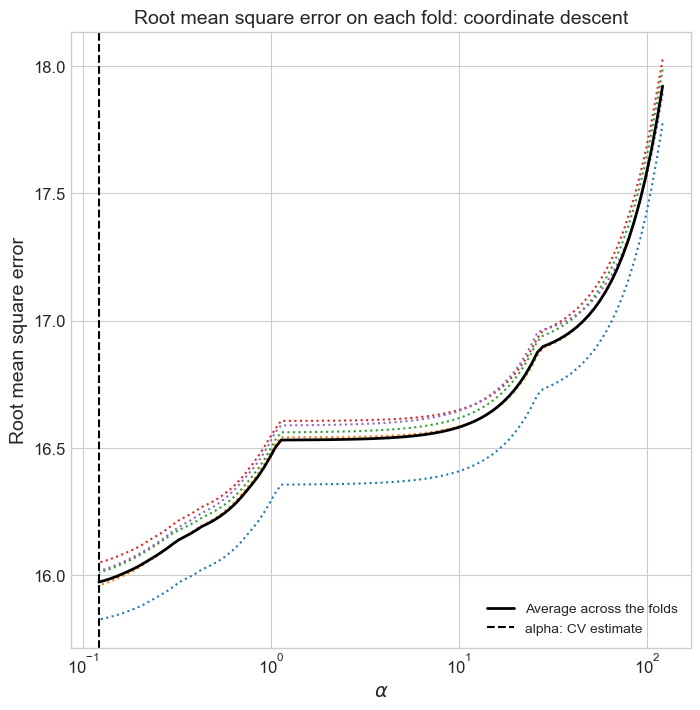

In [28]:
plt.figure(figsize=S)
plt.semilogx(lasso.alphas_, np.sqrt(lasso.mse_path_), ":")
plt.plot(
    lasso.alphas_,
    np.sqrt(lasso.mse_path_.mean(axis=-1)),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    lasso.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)
plt.legend()
plt.xlabel(r"$\alpha$")
plt.ylabel("Root mean square error")
plt.title("Root mean square error on each fold: coordinate descent")
plt.axis("tight");

The Lasso model performs best for low $\alpha$ values. Below we can see how much that results in beta coefficients being pushed to zero.

In [29]:
print("Best Lasso model:\n"
      f"  RMSE: {np.sqrt(mean_squared_error(lasso.predict(X_train), t1_eq)):.2f}\n"
      f"  alpha: {lasso.alpha_:.4f}")

Best Lasso model:
  RMSE: 15.97
  alpha: 0.1211


By ranking the (absolute) regression coefficients from high to low, we can find the excluded variables (due to the LASSO penalty) at the bottom of the list:

In [30]:
pd.concat({'coef_abs': pd.Series(abs(lasso.coef_)), 'coef': pd.Series(lasso.coef_), 'feature': X_columns}, axis=1).sort_values('coef_abs', ascending=False)

,coef_abs,coef,feature
17,3.57,3.57,t0_disability
13,2.99,-2.99,depression
19,2.34,-2.34,t0_self_care
22,2.21,-2.21,t0_anxiety
7,2.06,-2.06,lung_disease
3,1.77,-1.77,heart_disease
6,1.46,-1.46,circulation
8,1.32,-1.32,diabetes
32,1.07,-1.07,oks_t0_limping
36,0.74,0.74,oks_t0_shopping


### Question 6
True assessment of model performance is not done by looking at the performance on the train set, but by evaluating performance on the test set. Use the developed LASSO model to predict outcomes for the test set, and compare the RMSE for the test set with the RMSE obtained above during cross-validation.

## KNN

The next algorithm we apply is K nearest neighbor, which makes its prediction for a patient based on the outcomes for the K most comparable patients. This algorithm again has a tuning parameter / hyperparameter (K; indicating the number of most comparable patients to consider) that needs to be tuned using cross-validation.

There are other hyperparameters to consider, such as how to determine the comparability/distance between instances, and whether to weigh comparable instances with regards to how comparable they are. 

In the example below, we only focus on the hyperparameter K.

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from collections import defaultdict

n_neighbors = [1, 3, 5]
knn = defaultdict(dict) # use defaultdict for nested dicts
for n in n_neighbors:
    knn[n]["model"] = KNeighborsRegressor(n_neighbors=n, n_jobs=-1).fit(X_train, t1_eq)
    knn[n]["cross validation scores"] = cross_val_score(
        knn[n]["model"], X_train, t1_eq, scoring="neg_mean_squared_error", cv=5
    )

The graph below shows that these knn models result in very poor performance, which is expected as we used all available features and knn is not good at handling a large number of features. 

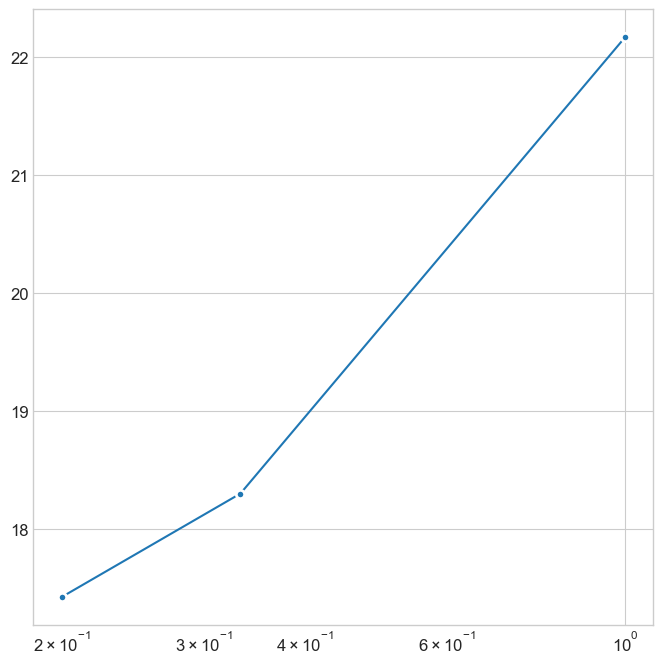

In [32]:
# plot 1/K vs. error rate (such that the X-axis goes from low to high flexibility)
knn_rmse = [np.sqrt(np.mean(-knn[n]['cross validation scores'])) for n in n_neighbors]
plt.figure(figsize=S)
plt.semilogx([1/n for n in n_neighbors], knn_rmse, 'o-', markeredgecolor='w', markeredgewidth='2');

We could for example only work with the top-3 features found in the importance ranking earlier in this notebook, to see whether that improves performance, which will also speed up computational time considerably.

In [33]:
print(X_columns[X_columns=='t0_eq_vas'])
print(X_columns[X_columns=='oks_t0_score'])
print(X_columns[X_columns=='t0_self_care'])

39    t0_eq_vas
dtype: object
38    oks_t0_score
dtype: object
19    t0_self_care
dtype: object


In [34]:
subset = X_train[:,[39, 38, 19]]

### Question 7 

- Retrain the knn model using only the subset of features defined above, and add a larger range for the hyperparameter n_neighbors, containing: [1, 2, 3, 5, 10, 20, 30, 50, 100, 200, 300]. Use the same loop as was applied in the KNN model trained above. 
- After running the model, plot the RMSE values for each of the hyperparameter values as was done above.

This already looks better, but we have overlooked one important aspect of training knn models, which is to standardize features.

### Question 8 (bonus)
- Standardize the subset of features and retrain the knn model, while setting the `weights` hyperparameter to distance (make sure to check the documentation for the appropriate settings).
- Plot the performance
- Explain why performance did not improve

# Summary

We considered three basic machine learning algorithms:
- Regression
- LASSO
- KNN

and applied them for modeling a numeric outcome. LASSO and KNN both used a hyperparameter and therefore needed to be tuned using cross-validation, which allowed us to compare performance for all possible hyperparameter settings. Regression is often used at the start, simply to quickly generate a baseline model. 

Quickly working towards a baseline model is good practice, as it forces you to set up your full pipeline, and in such a way that it can be tweaked relatively easily.

A strategy for quickly getting started, would be to: 
- Run a regression to get baseline performance and check your results for face validity
- Run LASSO and compare performance
- With the selected variables in your LASSO, run KNN and compare performance

The next notebook will look at more sophisticated machine learning algorithms that tend to perform better than the models considered in this notebook. In that notebook, a binary outcome instead of a numeric outcome will be modeled. 
